# Predictive Modeling for Addressing Homelessness in California

## Project Overview
Homelessness is a critical and complex issue in the U.S., shaped by a variety of factors such as housing availability, economic conditions, and local policies. This project aims to develop predictive models to anticipate trends in homelessness, focusing on California counties, with the goal of optimizing resource allocation and supporting public services.

### Objectives
1. **Prediction Focus:** Develop a predictive model for homelessness rates by using socioeconomic and demographic data.
2. **Exploration and Insights:** Identify key contributing factors to homelessness through exploratory data analysis (EDA).
3. **Scalable Solution:** Validate the model's generalizability to counties across the U.S.

In [45]:
# Loading dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

## **Data Sources**

The primary dataset is from the **U.S. Department of Housing and Urban Develeopment's Office of Policy Development**. This dataset was made to analyze market predictors of homeless, and how community factors shape homelessness rates within continuums of care.

The granularity of this dataset is CoC nnumber pear year. And each row has specific factors like:

- Climate
- Demographics
- Economic
- Geography
- Housing
- Local Policies
- Safety Nets
- Subgroups

In [46]:
data = pd.read_csv("data/05b_analysis_file_update.csv")
data.head()

,year,cocnumber,pit_tot_shelt_pit_hud,pit_tot_unshelt_pit_hud,pit_tot_hless_pit_hud,pit_ind_shelt_pit_hud,pit_ind_unshelt_pit_hud,pit_ind_hless_pit_hud,pit_perfam_shelt_pit_hud,pit_perfam_unshelt_pit_hud,...,sub_high_cost_rent75,sub_high_cost_homeval75,sub_high_rent_share75,tight_high_cost_rental_mkt,sub_tight_high_cost_rent,sub_west_coast_all_urb,sub_west_census,major_city,suburban,rural
0,2010,AK-500,1113.0,118.0,1231.0,633.0,107.0,740.0,480.0,11.0,...,1,1,1,3,1,1,1,1,0,0
1,2011,AK-500,1082.0,141.0,1223.0,677.0,117.0,794.0,405.0,24.0,...,1,1,0,3,1,1,1,1,0,0
2,2012,AK-500,1097.0,50.0,1147.0,756.0,35.0,791.0,341.0,15.0,...,1,1,1,3,1,1,1,1,0,0
3,2013,AK-500,1070.0,52.0,1122.0,792.0,52.0,844.0,278.0,0.0,...,1,1,0,3,1,1,1,1,0,0
4,2014,AK-500,970.0,53.0,1023.0,688.0,48.0,736.0,282.0,5.0,...,1,1,1,3,1,1,1,1,0,0


**Features**
We organized and collected features in different categories in the `total_features.py` file. As you will see, each category has a lot of features.

In [47]:
from total_features import *

for category_name, features in feature_categories.items():
    print(f"{category_name}: {len(features)} features")
print("Total number of features:", sum(len(features) for features in feature_categories.values()))

climate_feats: 8 features
demographic_feats: 93 features
economic_feats: 34 features
housing_feats: 62 features
local_policies_feats: 45 features
Total number of features: 242


This dateset is extremely large with lots of features. We think it would be easier if we can shorten the amount of variables use as a lot aren't very diffrent to each other.

## **Exploratory Data Analysis**

Let's select three features from each category (that we'll be predicting on) and compare to see how it relates toward **total homeless** from the `outcomes` array. There isn't much data that we need to create just because the dataset is super rich with data.

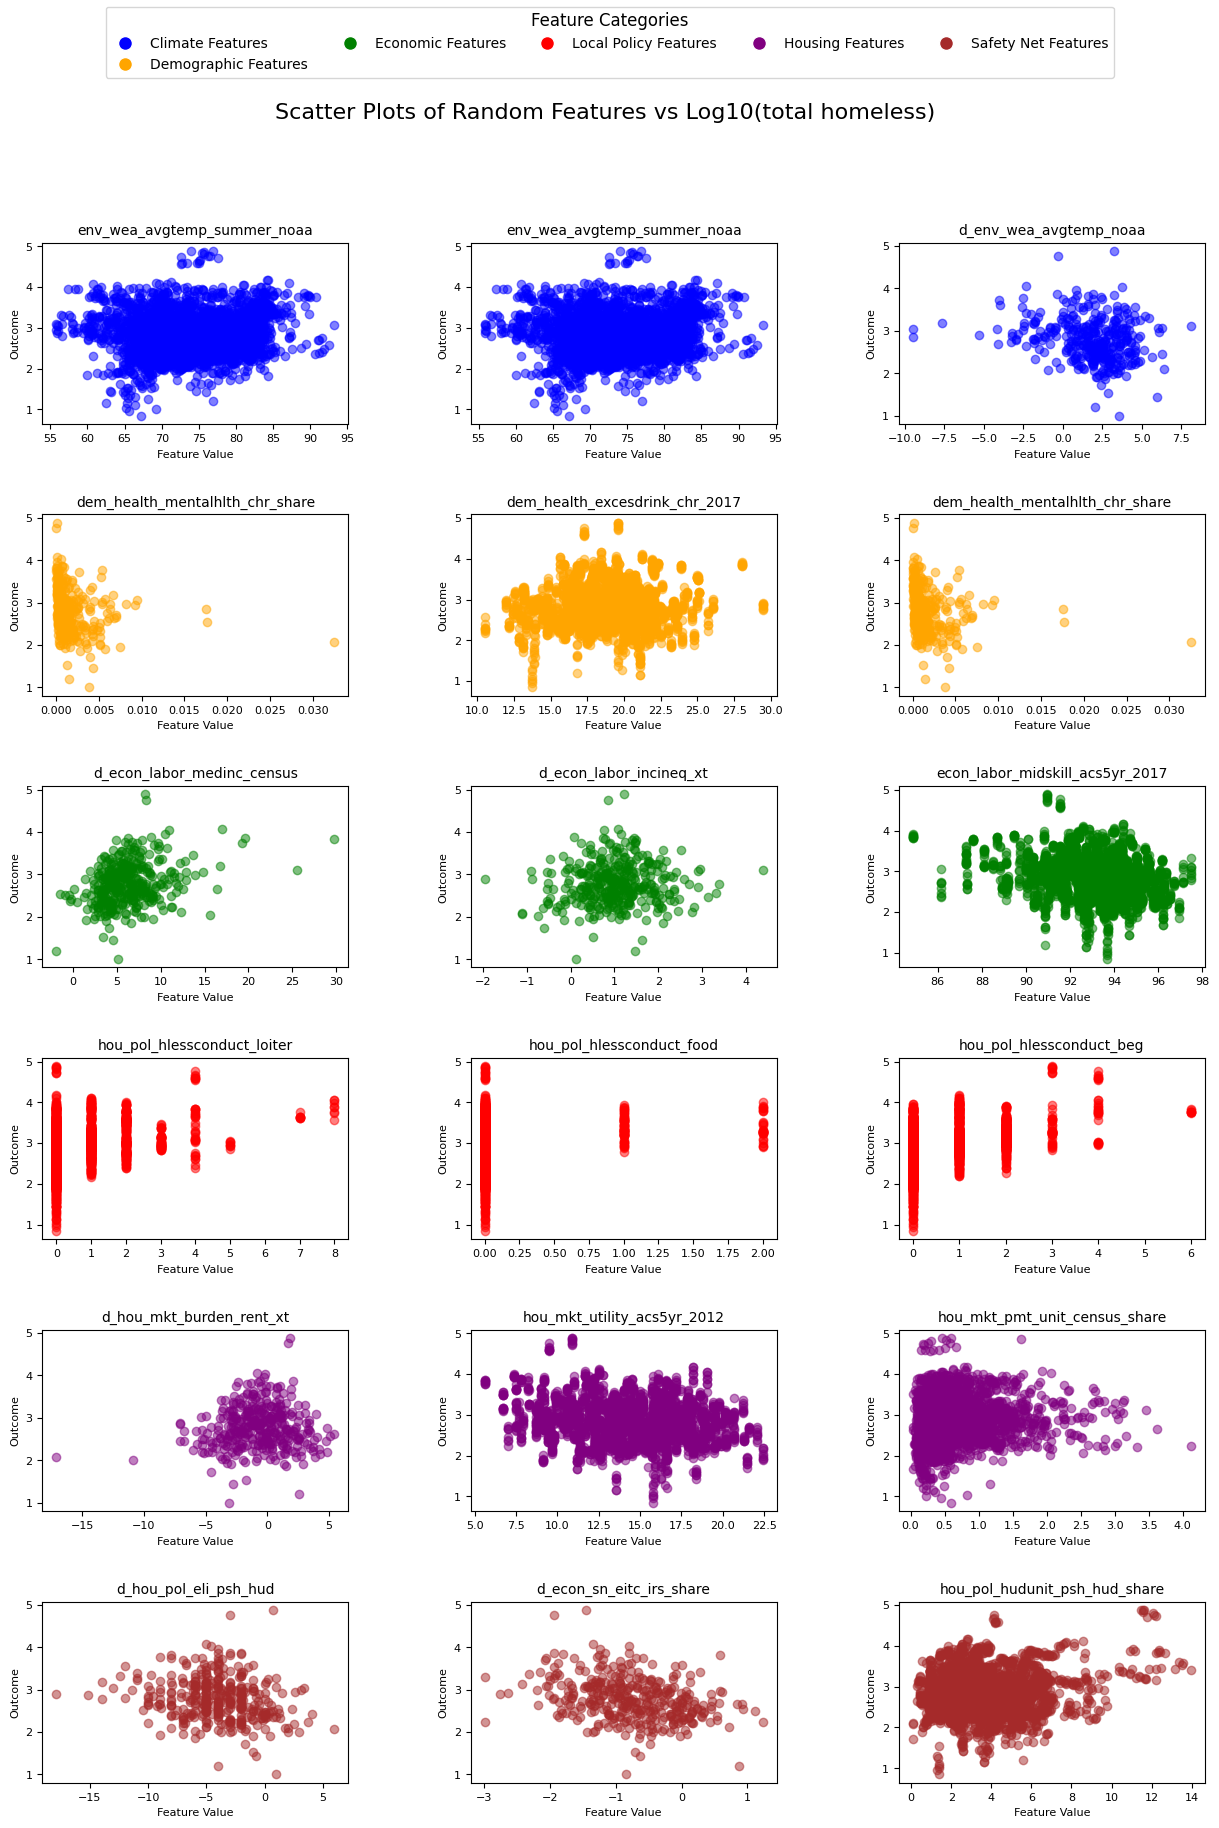

In [48]:
total_homeless = data['pit_tot_hless_pit_hud']
total_feats = [climate_feats, demographic_feats, economic_feats, local_policies_feats, housing_feats, safety_net_feats]
category_labels = [
    "Climate Features",
    "Demographic Features",
    "Economic Features",
    "Local Policy Features",
    "Housing Features",
    "Safety Net Features"
]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

fig, axes = plt.subplots(6, 3, figsize=(15, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for i, feature_category in enumerate(total_feats):
    for j in range(3):  # Select 3 random features from each category
        feature_idx = np.random.choice(len(feature_category))
        category = feature_category[feature_idx]
        x = data[category]
        ax = axes[i, j]
        ax.scatter(x, np.log10(total_homeless), alpha=0.5, color=colors[i], label=category_labels[i] if j == 0 else "")
        ax.set_title(f"{category}", fontsize=10)
        ax.set_xlabel("Feature Value", fontsize=8)
        ax.set_ylabel("Outcome", fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=8)

fig.suptitle("Scatter Plots of Random Features vs Log10(total homeless)", fontsize=16, y=0.95)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=label) 
           for i, label in enumerate(category_labels)]
fig.legend(handles=handles, loc='upper center', ncol=5, fontsize=10, title="Feature Categories", title_fontsize=12)
plt.show()

Looking at distribution of number of total number of homeless people.

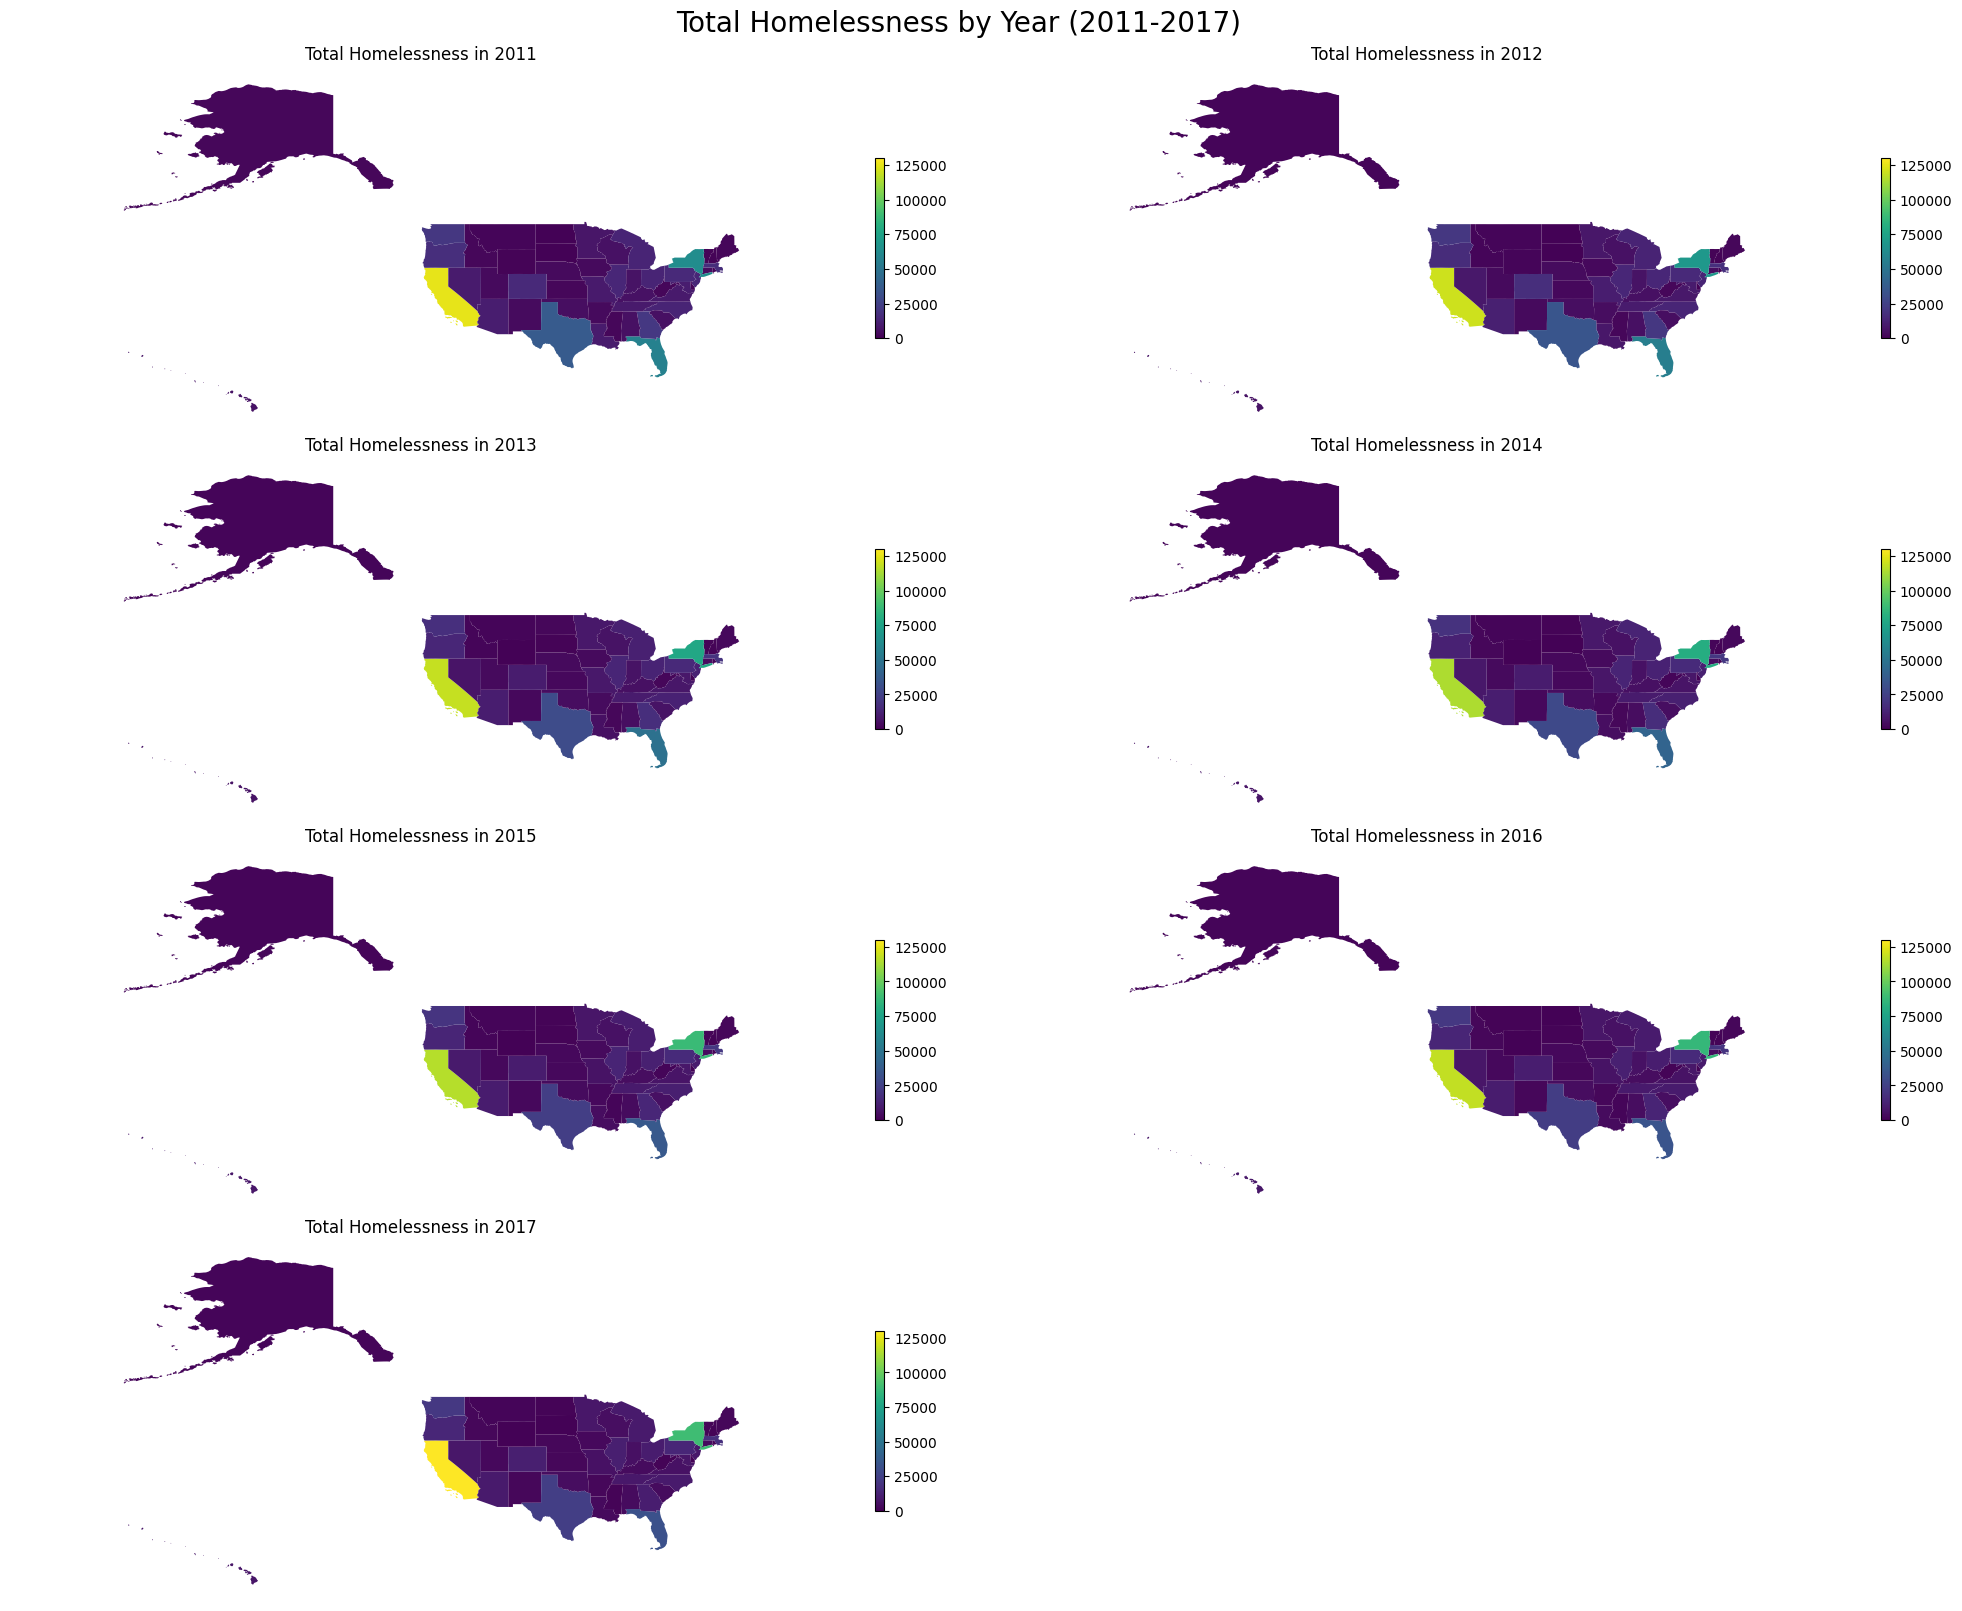

In [49]:
total_homeless_by_year_area = data.pivot_table(
    index='state_abr',
    columns='year',
    values='pit_tot_hless_pit_hud',
    aggfunc='sum')

total_homeless_by_year_area = total_homeless_by_year_area.sort_index()
states_map = gpd.read_file('data/tl_2024_us_state.shp')

total_homeless_by_year_area_df = total_homeless_by_year_area.reset_index()
merged = states_map.merge(total_homeless_by_year_area_df, left_on="STUSPS", right_on="state_abr", how="left")

years_to_plot = list(range(2011, 2018))  # Years 2011 to 2017
fig, axes = plt.subplots(4, 2, figsize=(20, 16), constrained_layout=True)
axes = axes.flatten()

for i, year in enumerate(years_to_plot):
    ax = axes[i]
    merged.plot(
        column=year, 
        ax=ax, 
        cmap="viridis", 
        legend=True, 
        legend_kwds={'shrink': 0.5},
        vmin=0,
        vmax=130000
    )
    ax.set_xlim(-200, -50)
    ax.axis("off")
    ax.set_title(f"Total Homelessness in {year}", fontsize=12)

for j in range(len(years_to_plot), len(axes)):
    axes[j].axis("off")

plt.suptitle("Total Homelessness by Year (2011-2017)", fontsize=20)
plt.show()


Here are some features that we think are important to predict on. We chose them based on absolute linear correlation, this should be useful for 

In [50]:
absolute_correlations = pd.Series(
    data[sum(feature_categories.values(), [])].corrwith(total_homeless).abs())

selected_features = {
    category: absolute_correlations[features].nlargest(top_n).index.tolist()
    for category, top_n in [
        ('climate_feats', 5),
        ('demographic_feats', 20),
        ('economic_feats', 20),
        ('housing_feats', 20),
        ('local_policies_feats', 5),
        ('safety_net_feats', 20)
    ]
}

for category, features in selected_features.items():
    print(f"\nCategory: {category}")
    print(f"Selected Features ({len(features)}):")
    for feature in features:
        print(f"  - {feature}")

# we should also add state identifier and year for forecasting 
# and cateogorical handling since some states have more homelessness rates than others
selected_features = sum(list(selected_features.values()), []) + ['state_abr', 'year']


Category: climate_feats
Selected Features (5):
  - hou_pol_temp_bed_hic_hud
  - hou_pol_bed_psh_hic_hud
  - hou_pol_hudunit_psh_hud
  - hou_pol_perm_bed_hic_hud
  - hou_pol_bed_es_hic_hud

Category: demographic_feats
Selected Features (20):
  - hou_pol_temp_bed_hic_hud
  - hou_pol_bed_psh_hic_hud
  - hou_pol_hudunit_psh_hud
  - hou_pol_perm_bed_hic_hud
  - hou_pol_bed_es_hic_hud
  - hou_pol_fedfundcoc
  - econ_sn_ssi_pay_SSA
  - econ_sn_ssi_part_SSA
  - hou_pol_bed_th_hic_hud
  - hou_pol_fund_project
  - econ_sn_eitc_irs
  - econ_sn_returns_irs
  - hou_pol_bed_sh_hic_hud
  - econ_sn_ssdi_SSA
  - d_hou_pol_fedfundcoc
  - hou_pol_bed_rrh_hic_hud
  - hou_pol_bed_oph_hic_hud
  - hou_pol_hudunit_psh_hud_share
  - d_econ_sn_ssi_part_rate_SSA
  - econ_sn_ssi_part_rate_SSA

Category: economic_feats
Selected Features (20):
  - hou_pol_temp_bed_hic_hud
  - hou_pol_bed_psh_hic_hud
  - hou_pol_hudunit_psh_hud
  - hou_pol_perm_bed_hic_hud
  - hou_pol_bed_es_hic_hud
  - hou_pol_fedfundcoc
  - econ_

## **Predicting Homelessness**

The first model we'll try is the one used by **HUD** to predict homelessness rates. It considers five main categories of factors:

1. **Housing market variables** ($M_i$): such as rent costs and vacancy rates.
2. **Economic variables** ($E_i$): like unemployment rates and income levels.
3. **Safety net variables** ($S_i$): such as available support programs for the homeless.
4. **Demographic variables** ($D_i$): like population characteristics (age, race, etc.).
5. **Climate variables** ($W_i$): including weather and environmental factors.

--include each weight as a vector that represents the individual weight for each column in the category family--

The formula for the HUD model is:

$$
\hat{H_i} = \hat{\alpha} + \hat{\beta}M_i + \hat{\gamma}E_i + \hat{\delta}S_i + \hat{\lambda}D_i + \hat{\rho}W_i
$$

We want to test how accurate this baseline model is at predicting homelessness rates. Additionally, we added two new variables—**year** ($Y_i$) and **state** ($A_i$)—to see if they improve the model's performance. These additions could help capture changes over time and differences between states. We will also perform a log10 transformation on the total number of homeless, just because since these datapoints are so large, we think normalizing them a bit will help. 

The updated formula becomes:

$$
\log_{10}(\hat{H_i}) = \hat{\alpha} + \hat{\beta}M_i + \hat{\gamma}E_i + \hat{\delta}S_i + \hat{\lambda}D_i + \hat{\rho}W_i + \hat{\eta}Y_i + \hat{\kappa}A_i
$$

### **Data Preprocessing**

In [51]:
X = data.copy()[selected_features].fillna(0)
X = pd.get_dummies(X, columns = ['state_abr'], drop_first=True,dtype = float)

# Prepare target variable `y`
y = np.log10(data['pit_tot_hless_pit_hud']).fillna(0)  # Ensure no missing values in target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (for faster processing time)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for easier interpretability
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

### **Model 1: Linear Regerssion**

In [52]:
# Initialize and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_pred_train_lr = linear_model.predict(X_train)
y_pred_test_lr = linear_model.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_pred_train_lr)
mse_test = mean_squared_error(y_test, y_pred_test_lr)
r2_train = r2_score(y_train, y_pred_train_lr)
r2_test = r2_score(y_test, y_pred_test_lr)

# Print evaluation metrics
print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train R^2:", r2_train)
print("Test R^2:", r2_test)

Train MSE: 0.09389962997706623
Test MSE: 0.11246030928574888
Train R^2: 0.6789881552700199
Test R^2: 0.6243032362040726


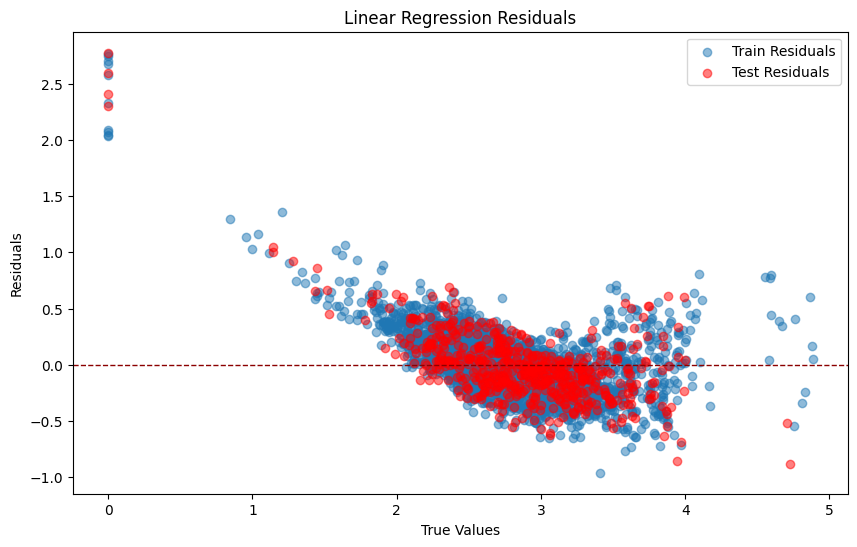

In [53]:
# Residuals plot
LR_train_residuals = y_pred_train_lr - y_train
LR_test_residuals = y_pred_test_lr - y_test

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_train, LR_train_residuals, alpha=0.5, label="Train Residuals")
ax.scatter(y_test, LR_test_residuals, alpha=0.5, label="Test Residuals", color="red")
ax.axhline(0, color="darkred", linestyle="--", linewidth=1)
ax.set_xlabel("True Values")
ax.set_ylabel("Residuals")
ax.set_title("Linear Regression Residuals")
ax.legend()
plt.show()

LR_residuals_plot = fig

### Model 2: Simple Regression Tree

In [54]:
regr_tree = DecisionTreeRegressor()
regr_tree.fit(X_train, y_train)

# Make predictions
y_pred_train_rt = regr_tree.predict(X_train)
y_pred_test_rt = regr_tree.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_pred_train_rt)
mse_test = mean_squared_error(y_test, y_pred_test_rt)
r2_train = r2_score(y_train, y_pred_train_rt)
r2_test = r2_score(y_test, y_pred_test_rt)

# Print evaluation metrics
print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train R^2:", r2_train)
print("Test R^2:", r2_test)

Train MSE: 0.0
Test MSE: 0.07508250049847116
Train R^2: 1.0
Test R^2: 0.749171484285111


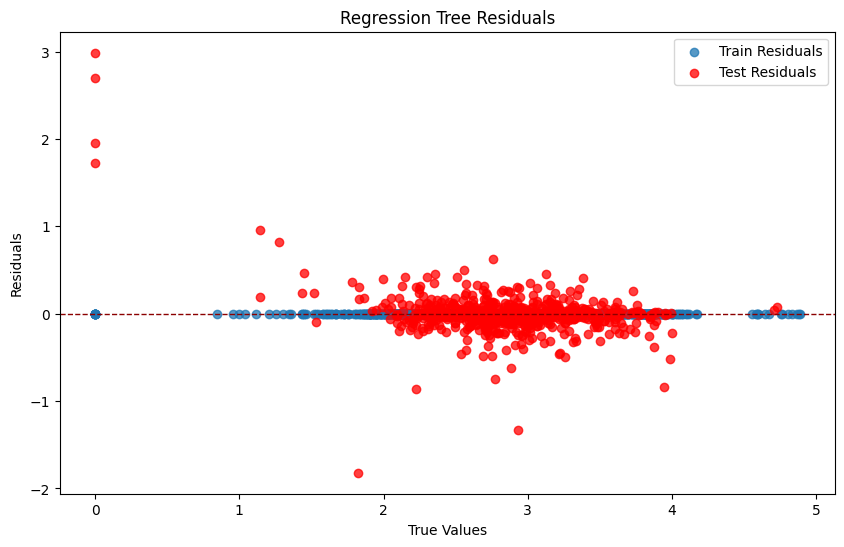

In [55]:
# Residuals plot
RT_train_residuals = y_pred_train_rt - y_train
RT_test_residuals = y_pred_test_rt - y_test

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_train, RT_train_residuals, alpha=0.75, label="Train Residuals")
ax.scatter(y_test, RT_test_residuals, alpha=0.75, label="Test Residuals", color="red")
ax.axhline(0, color="darkred", linestyle="--", linewidth=1)
ax.set_xlabel("True Values")
ax.set_ylabel("Residuals")
ax.set_title("Regression Tree Residuals")
ax.legend()
plt.show()

RT_residuals_plot = fig

The MSE on the test set is improving, but let's see if we can improve this with cross-validation.

### Model 3: Cross-Validated and Parameter Searched Regression Tree

In [56]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'ccp_alpha': np.arange(.01, .25, .001)
}

# Perform a grid search with cross-validation
new_regr_tree = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=new_regr_tree, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Use the best model from the grid search
cv_regr_tree = grid_search.best_estimator_
cv_regr_tree.fit(X_train, y_train)

# Make predictions with the best model
y_pred_train_cv = cv_regr_tree.predict(X_train)
y_pred_test_cv = cv_regr_tree.predict(X_test)

# Evaluate the best model
mse_train = mean_squared_error(y_train, y_pred_train_cv)
mse_test = mean_squared_error(y_test, y_pred_test_cv)
r2_train = r2_score(y_train, y_pred_train_cv)
r2_test = r2_score(y_test, y_pred_test_cv)

# Print evaluation metrics and best parameters
print("Best Parameters:", grid_search.best_params_)
print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train R^2:", r2_train)
print("Test R^2:", r2_test)

Best Parameters: {'ccp_alpha': 0.01}
Train MSE: 0.08800541531015633
Test MSE: 0.10984738021106873
Train R^2: 0.699138529919221
Test R^2: 0.6330322625033984


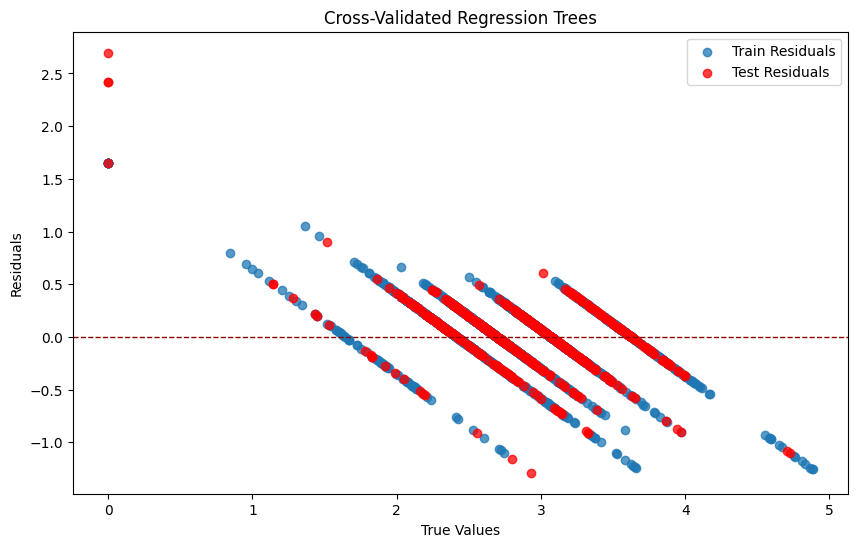

In [57]:
# Residuals plot
CV_train_residuals = y_pred_train_cv - y_train
CV_test_residuals = y_pred_test_cv - y_test

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_train, CV_train_residuals, alpha=0.75, label="Train Residuals")
ax.scatter(y_test, CV_test_residuals, alpha=0.75, label="Test Residuals", color="red")
ax.axhline(0, color="darkred", linestyle="--", linewidth=1)
ax.set_xlabel("True Values")
ax.set_ylabel("Residuals")
ax.set_title("Cross-Validated Regression Trees")
ax.legend()
plt.show()

CV_residuals_plot = fig

### Model 4: Random Forest

In [58]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Perform grid search with cross-validation
rf.fit(X_train, y_train)

# Make predictions with the best model
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)

# Evaluate the best model
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rf)

# Print evaluation metrics
print("Train MSE (Random Forest):", mse_train_rf)
print("Test MSE (Random Forest):", mse_test_rf)
print("Train R^2 (Random Forest):", r2_train_rf)
print("Test R^2 (Random Forest):", r2_test_rf)

Train MSE (Random Forest): 0.0038576469105513736
Test MSE (Random Forest): 0.05416102774679531
Train R^2 (Random Forest): 0.9868119783712092
Test R^2 (Random Forest): 0.8190639615205916


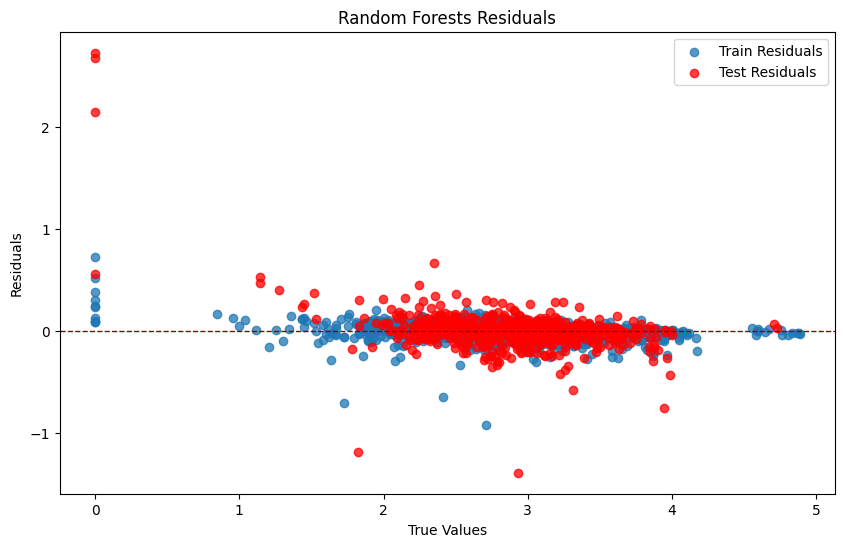

In [59]:
# Residuals plot
RF_train_residuals = y_pred_train_rf - y_train
RF_test_residuals = y_pred_test_rf - y_test

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_train, RF_train_residuals, alpha=0.75, label="Train Residuals")
ax.scatter(y_test, RF_test_residuals, alpha=0.75, label="Test Residuals", color="red")
ax.axhline(0, color="darkred", linestyle="--", linewidth=1)
ax.set_xlabel("True Values")
ax.set_ylabel("Residuals")
ax.set_title("Random Forests Residuals")
ax.legend()
plt.show()

RF_residuals_plot = fig

### Model 5: Gradient Boosting

In [60]:
# Initialize Gradient Boosting Regressor with a different variable name
gradient_boosting_model = GradientBoostingRegressor(random_state=42)

# Fit the model on training data
gradient_boosting_model.fit(X_train, y_train)

# Make predictions with the fitted model
y_pred_train_gbm = gradient_boosting_model.predict(X_train)
y_pred_test_gbm = gradient_boosting_model.predict(X_test)

# Evaluate the model
mse_train_gbm = mean_squared_error(y_train, y_pred_train_gbm)
mse_test_gbm = mean_squared_error(y_test, y_pred_test_gbm)
r2_train_gbm = r2_score(y_train, y_pred_train_gbm)
r2_test_gbm = r2_score(y_test, y_pred_test_gbm)

# Print evaluation metrics
print("Train MSE (Gradient Boosting):", mse_train_gbm)
print("Test MSE (Gradient Boosting):", mse_test_gbm)
print("Train R^2 (Gradient Boosting):", r2_train_gbm)
print("Test R^2 (Gradient Boosting):", r2_test_gbm)

Train MSE (Gradient Boosting): 0.02102904673562434
Test MSE (Gradient Boosting): 0.058781090326578904
Train R^2 (Gradient Boosting): 0.9281086295317194
Test R^2 (Gradient Boosting): 0.8036296934594125


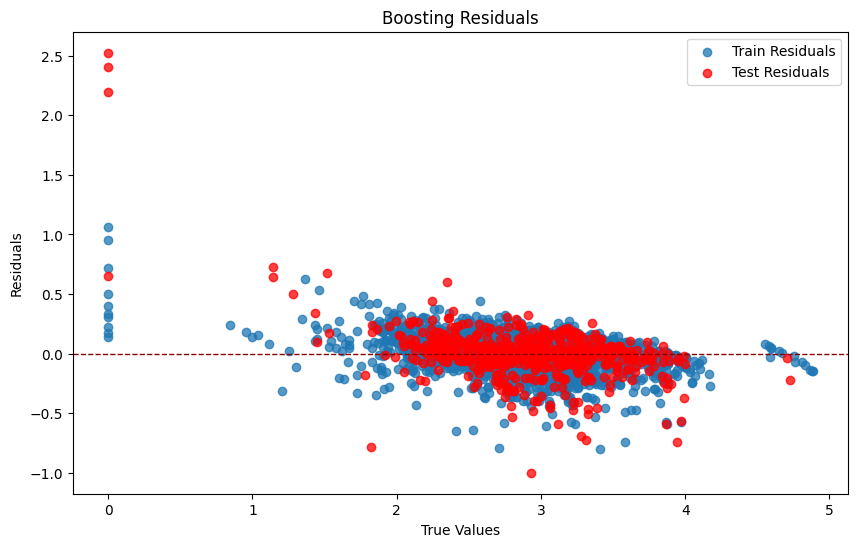

In [61]:
# Residuals plot
GBM_train_residuals = y_pred_train_gbm - y_train
GBM_test_residuals = y_pred_test_gbm - y_test

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_train, GBM_train_residuals, alpha=0.75, label="Train Residuals")
ax.scatter(y_test, GBM_test_residuals, alpha=0.75, label="Test Residuals", color="red")
ax.axhline(0, color="darkred", linestyle="--", linewidth=1)
ax.set_xlabel("True Values")
ax.set_ylabel("Residuals")
ax.set_title("Boosting Residuals")
ax.legend()
plt.show()

GBM_residuals_plot = fig

## Model Comparisons

Lets look at how the residuals for each model compare towards each other.

In [62]:
# List of residuals and titles
residuals = [
    (LR_train_residuals, LR_test_residuals),
    (RT_train_residuals, RT_test_residuals),
    (CV_train_residuals, CV_test_residuals),
    (RF_train_residuals, RF_test_residuals),
    (GBM_train_residuals, GBM_test_residuals)
]
titles = [
    "Linear Regression Residuals",
    "Regression Tree Residuals",
    "Cross-Validation Residuals",
    "Random Forest Residuals",
    "Gradient Boosting Residuals"
]

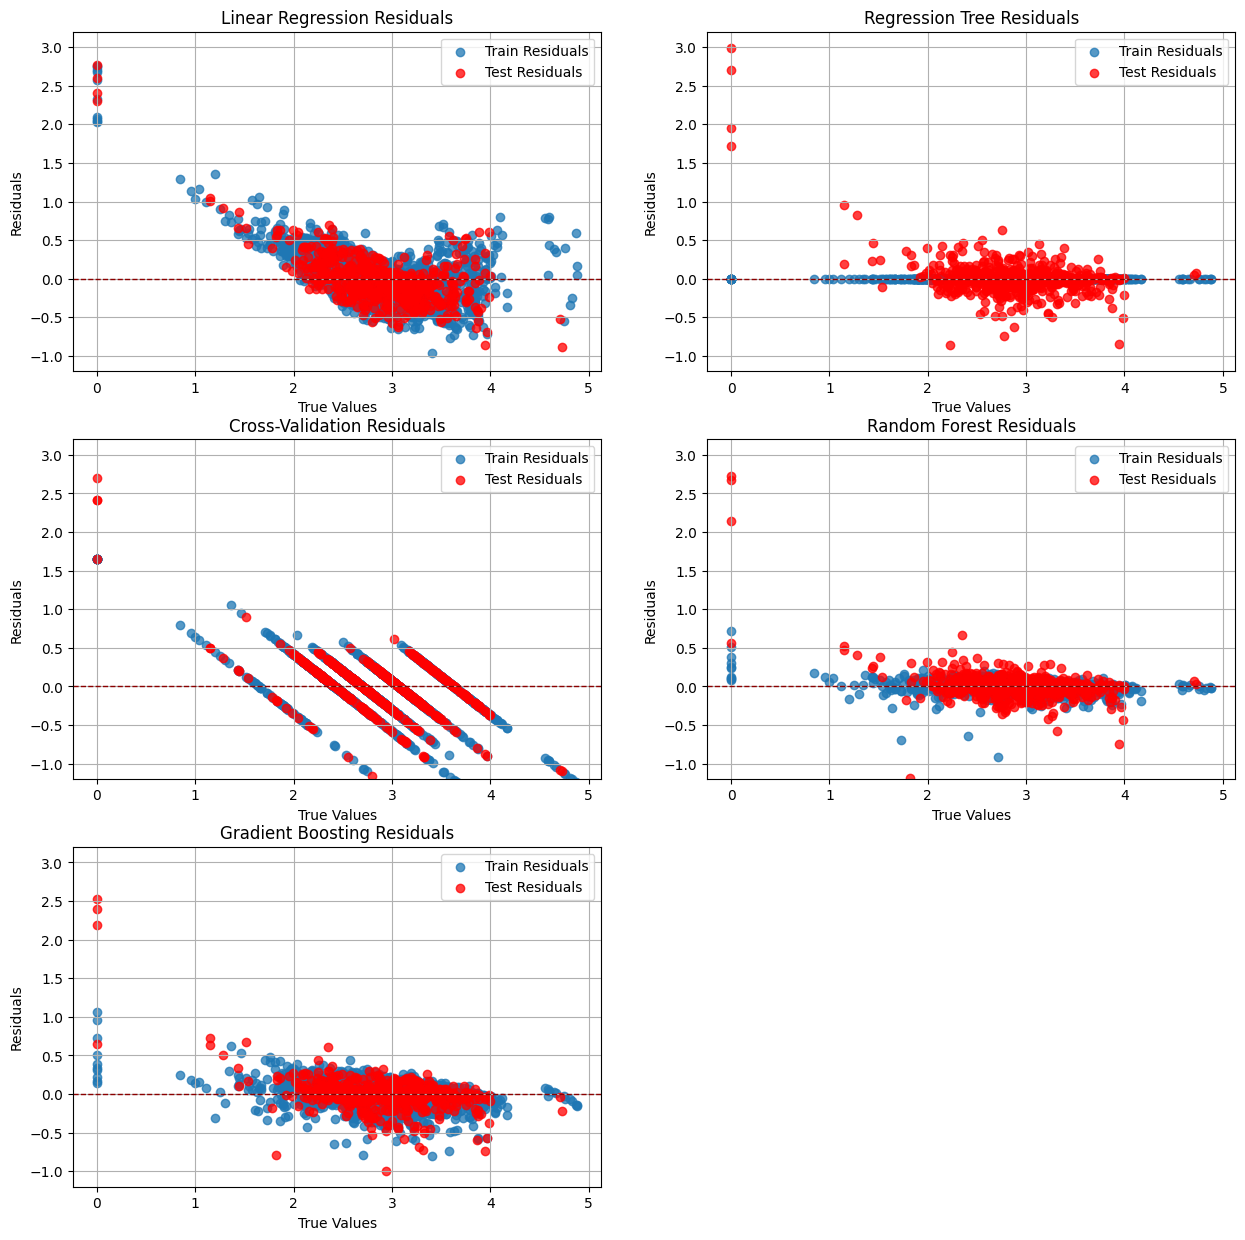

In [63]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.2, wspace=0.2)

for i, ((train_res, test_res), title) in enumerate(zip(residuals, titles)):
    row, col = divmod(i, 2)  # Determine subplot row and column
    ax = axes[row, col]
    ax.scatter(y_train, train_res, alpha=0.75, label="Train Residuals")
    ax.scatter(y_test, test_res, alpha=0.75, label="Test Residuals", color="red")
    ax.axhline(0, color="darkred", linestyle="--", linewidth=1)
    ax.set_ylim(-1.2, 3.2)  # Set the y-axis limits
    ax.set_title(title)
    ax.set_xlabel("True Values")
    ax.set_ylabel("Residuals")
    ax.legend()
    ax.grid(True)

# Turn off any unused subplot axes
if len(residuals) < len(axes.flatten()):
    for j in range(len(residuals), len(axes.flatten())):
        fig.delaxes(axes.flatten()[j])

plt.show()

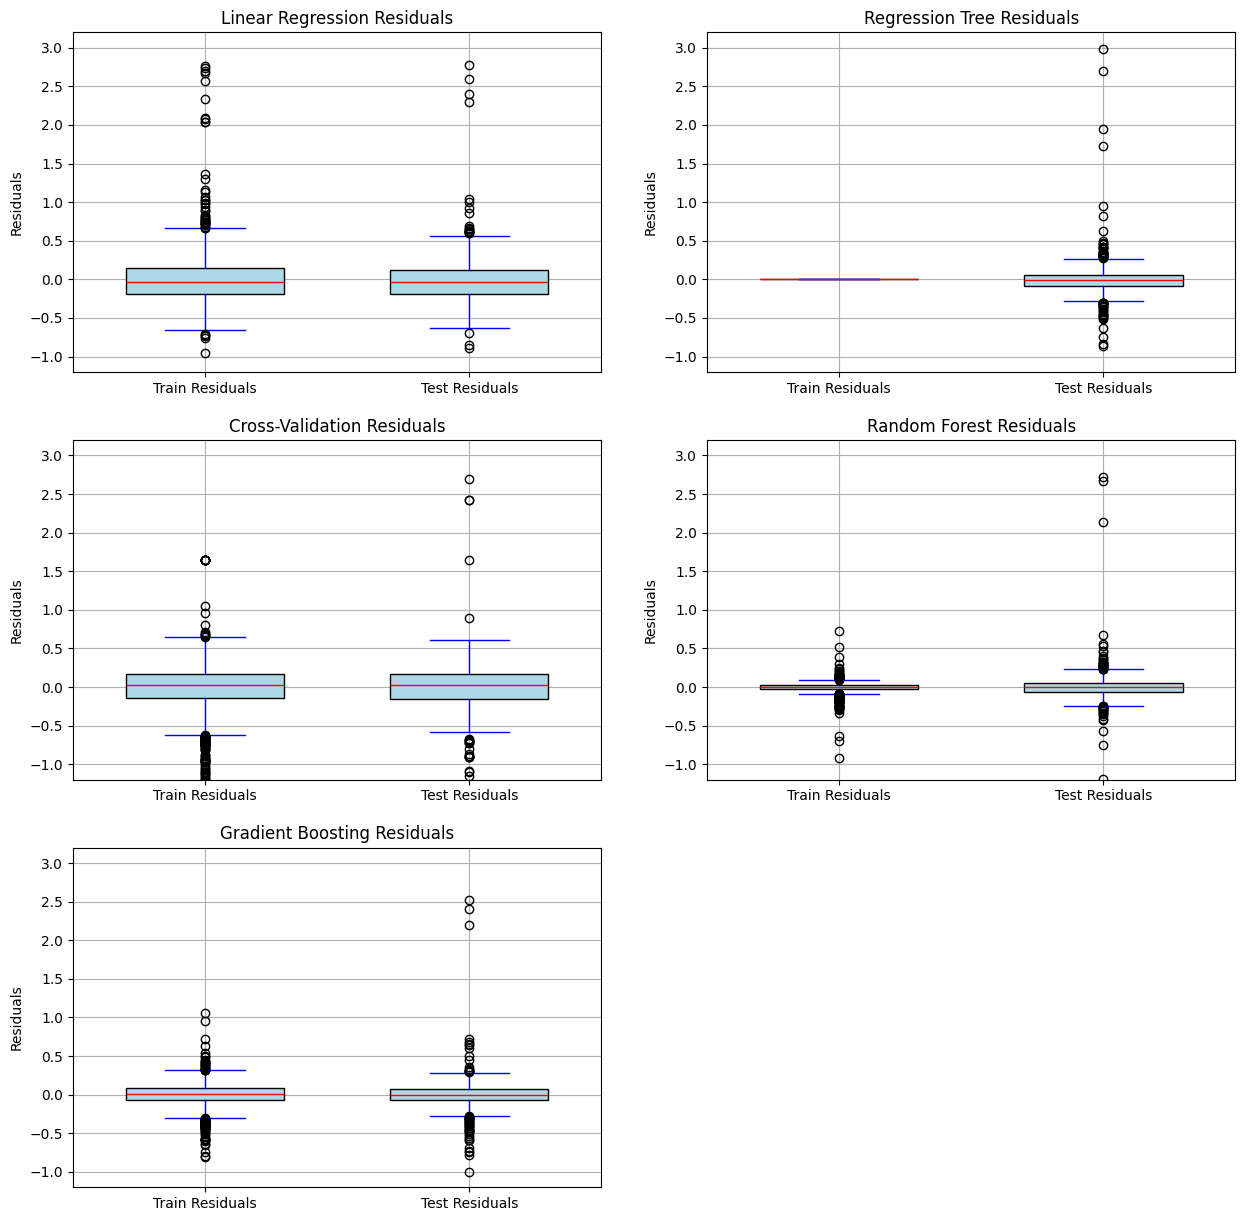

In [64]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.2, wspace=0.2)

for i, ((train_res, test_res), title) in enumerate(zip(residuals, titles)):
    row, col = divmod(i, 2)  # Determine subplot row and column
    ax = axes[row, col]
    
    # Create boxplots for train and test residuals
    ax.boxplot(
        [train_res, test_res],
        positions=[1, 2],
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor="lightblue"),
        medianprops=dict(color="red"),
        whiskerprops=dict(color="blue"),
        capprops=dict(color="blue")
    )
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["Train Residuals", "Test Residuals"])
    ax.set_ylim(-1.2, 3.2)
    ax.set_title(title)
    ax.set_ylabel("Residuals")
    ax.grid(True)

if len(residuals) < len(axes.flatten()):
    for j in range(len(residuals), len(axes.flatten())):
        fig.delaxes(axes.flatten()[j])
plt.show()

**Bootstrap Aggregation**

We can simply choose a model with the best $R^2$ value but let's truly confirm how accurate our dataset can be by performing bootstrap samples.

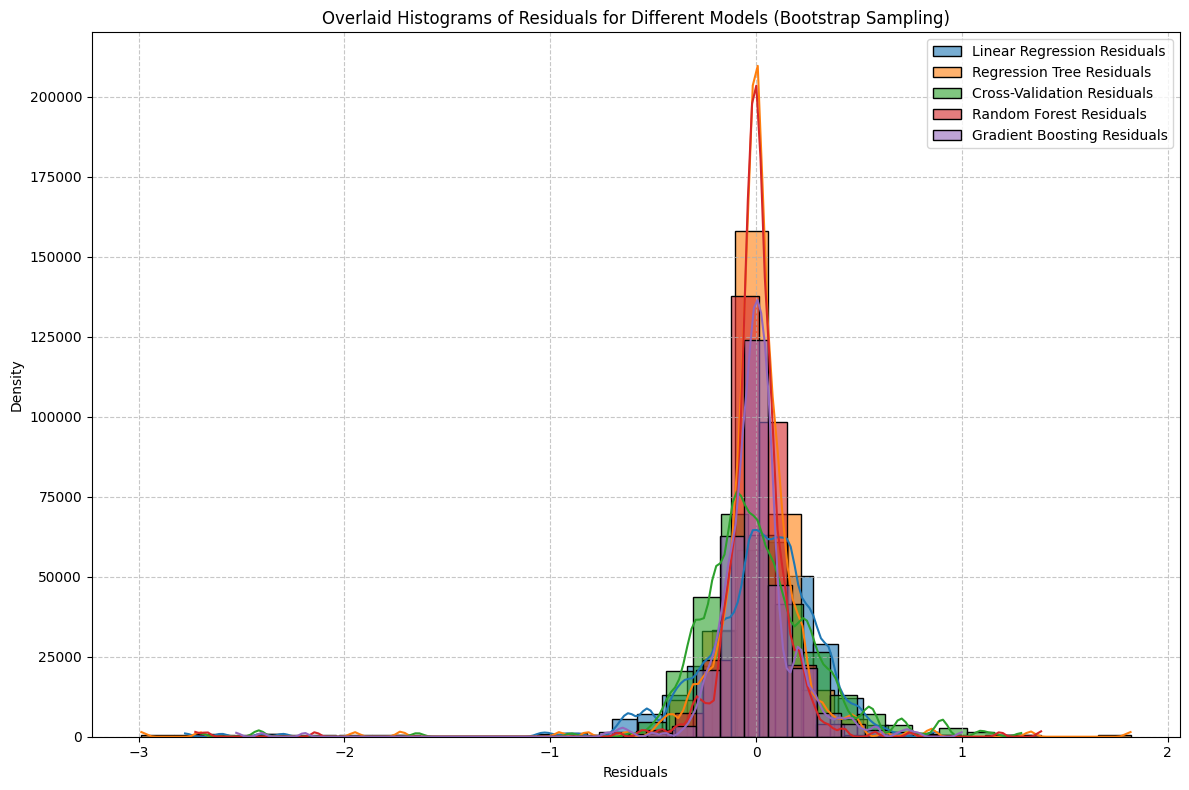

In [65]:
models = [linear_model, regr_tree, cv_regr_tree, rf, gradient_boosting_model]

# Perform bootstrapping for each model and calculate residuals
bootstrap_residuals = {}
for model, title in zip(models, titles):
    np.random.seed(2024)
    residuals = []
    for _ in range(500):  # 500 iterations
        indices = np.random.choice(len(X_test), size=len(X_test), replace=True) # REPLACE WITH WHOLE DATASET
        X_bootstrap = X_test.iloc[indices, :]
        y_bootstrap = y_test.iloc[indices]
        y_pred_bootstrap = model.predict(X_bootstrap)
        residuals.extend(y_bootstrap - y_pred_bootstrap)  # Collect residuals
    bootstrap_residuals[title] = residuals

# Plot overlaid histograms of residuals for each model
plt.figure(figsize=(12, 8))
for title, residuals in bootstrap_residuals.items():
    sns.histplot(residuals, kde=True, label=title, bins=30, alpha=0.6)

plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("Overlaid Histograms of Residuals for Different Models (Bootstrap Sampling)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()